# Project Final Report

### Due: Midnight on April 27 (2-hour grace period) — 50 points  

### No late submissions will be accepted.


## Overview

Your final submission consists of **three components**:

---

### 1. Final Report Notebook [40 pts]

Complete all sections of this notebook to document your final decisions, results, and broader context.

- **Part A**: Select the single best model from your Milestone 2 experiments. Now that you’ve finalized your model, revisit your decisions from Milestones 1 and 2. Are there any steps you would change—such as cleaning, feature engineering, or model evaluation—given what you now know?

- **Part B**: Write a technical report following standard conventions, for example:
  - [CMU guide to structure](https://www.stat.cmu.edu/~brian/701/notes/paper-structure.pdf)
  - [Data science report example](https://www.projectpro.io/article/data-science-project-report/620)
  - The Checklist given in this week's Blackboard Lesson (essentially the same as in HOML).
    
  Your audience here is technically literate but unfamiliar with your work—like your manager or other data scientists. Be clear, precise, and include both code (for illustration), charts/plots/illustrations, and explanation of what you discovered and your reasoning process. 

The idea here is that Part A would be a repository of the most important code, for further work to come, and Part B is
the technical report which summarizes your project for the data science group at your company. Do NOT assume that readers of Part B are intimately familiar with Part A; provide code for illustration as needed, but not to run.

Submit this notebook as a group via your team leader’s Gradescope account.

---

### 2. PowerPoint Presentation [10 pts]

Create a 10–15 minute presentation designed for a general audience (e.g., sales or marketing team).

- Prepare 8–12 slides, following the general outline of the sections of Part B. 
- Focus on storytelling, visuals (plots and illustrations), and clear, simplified language. No code!
- Use any presentation tool you like, but upload a PDF version.
- List all team members on the first slide.

Submit as a group via your team leader’s Gradescope account.

---

### 3. Individual Assessment

Each team member must complete the Individual Assessment Form (same as in Milestone 1), sign it, and upload it via their own Gradescope account.

---

## Submission Checklist

-  Final Report Notebook — Team leader submission
-  PDF Slides — Team leader submission
-  Individual Assessment Form — Each member submits their own


## Part A: Final Model and Design Reassessment [10 pts]

In this part, you will finalize your best-performing model and revisit earlier decisions to determine if any should be revised in light of your complete modeling workflow. You’ll also consolidate and present the key code used to run your model on the preprocessed dataset, with thoughtful documentation of your reasoning.

**Requirements:**

- Reconsider **at least one decision from Milestone 1** (e.g., preprocessing, feature engineering, or encoding). Explain whether you would keep or revise that decision now that you know which model performs best. Justify your reasoning.
  
- Reconsider **at least one decision from Milestone 2** (e.g., model evaluation, cross-validation strategy, or feature selection). Again, explain whether you would keep or revise your original decision, and why.

- Below, include all code necessary to **run your final model** on the processed dataset. This section should be a clean, readable summary of the most important steps from Milestones 1 and 2, adapted as needed to fit your final model choice and your reconsiderations as just described. 

- Use Markdown cells and inline comments to explain the structure of the code clearly but concisely. The goal is to make your reasoning and process easy to follow for instructors and reviewers.

> Remember: You are not required to change your earlier choices, but you *are* required to reflect on them and justify your final decisions.


### Reconsider **at least one decision from Milestone 1** (e.g., preprocessing, feature engineering, or encoding). Explain whether you would keep or revise that decision now that you know which model performs best. Justify your reasoning. ###


Since our tuned Gradient Boosting model delivered the lowest RMSE and the most consistent cross-validation performance in Milestone 2, we would optimize our feature encoding to suit its strengths. In Milestone 1 we one-hot encoded every neighborhood, which inflated our feature set to over 500 sparse columns. Instead, we would first group any neighborhood appearing in less than 1 % of records into an “Other” category, then replace each remaining neighborhood label with a smoothed average of its homes’ tax-assessed values (using a small smoothing constant to pull noisy, small-sample means toward the overall mean).

This approach would produce a single numeric “neighborhood_encoded” feature instead of hundreds of dummies, preserving location information while speeding up Gradient Boosting training and reducing overfitting and computational overhead.

In [ ]:
# Previous Milestone 1 code

categorical_cols = df_modeling_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)

# One-hot encode regionidneighborhood
df_encoded = pd.get_dummies(df_modeling_clean, columns=categorical_cols, drop_first=True)

print("Final shape after encoding:", df_encoded.shape)
# Final shape after encoding: (76525, 509)

### Reconsider **at least one decision from Milestone 2** (e.g., model evaluation, cross-validation strategy, or feature selection). Again, explain whether you would keep or revise your original decision, and why. ###

In Milestone 2 we evaluated and tuned our models using a 5-fold cross-validation scheme, and our final Gradient Boosting model yielded an average RMSE of $176,484 with a standard deviation of about $1,066—clearly outperforming the other candidates. Because those five folds already give us a tight error distribution, they provide a reliable estimate of how the model will perform on new data.

Keeping 5-fold CV makes sense for a few reasons:

1. Efficiency vs. Benefit: Doubling to 10 folds or layering in repeats would ~double or triple our compute time—turning a 20-minute grid search into 40–60 minutes—while only shaving off a few dollars in error variance

2. Bias–Variance Tradeoff: With 5 splits we already strike an effective balance - more folds reduce bias but increase variance in small datasets, and here the variance is already small

3. Reproducibility and Consistency: All of our hyperparameter tuning, feature-selection experiments, and performance comparisons used the same 5-fold split structure. Changing that at the end could introduce subtle shifts in which hyperparameters look best

As a result, we would leave our original 5-fold CV strategy unchanged for the final workflow.

In [ ]:
# Previous Milestone 2 code

gb_grid = {
    "n_estimators":   [100, 200],
    "max_depth":      [3, 5],
    "learning_rate":  [0.05, 0.1],
    "subsample":      [0.8, 1.0]
}

gb = GradientBoostingRegressor(random_state=random_state)
X_gb = scaler.fit_transform(X_train_fe[gb_features])

gb_cv = GridSearchCV(
    estimator=gb,
    param_grid=gb_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)
gb_cv.fit(X_gb, y_train)

print(f"Best 5-fold CV RMSE: {-gb_cv.best_score_:.0f}")
print("Best params:", gb_cv.best_params_)


### Below, include all code necessary to **run your final model** on the processed dataset. This section should be a clean, readable summary of the most important steps from Milestones 1 and 2, adapted as needed to fit your final model choice and your reconsiderations as just described. ###

In [3]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))




/Users/chrismckee/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/chrismckee/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

# df.to_csv("zillow_dataset_cleaned.csv", index=False)


File already exists. Skipping download.


We start by making a dedicated copy of the original DataFrame for our regression task, then remove columns that are purely identifiers or unlikely to influence tax value (parcel IDs, census block codes, zoning descriptions, fireplace flag, assessment year) so the model only sees relevant, predictive features.

In [6]:
# Make a copy of the original dataset to use for the regression task
df_regression = df.copy()

columns_to_remove = [
    'parcelid',
    'rawcensustractandblock',
    'censustractandblock',
    'propertyzoningdesc',
    'propertycountylandusecode',
    'fireplaceflag',
    'assessmentyear'
]

# Drop the features from the new dataset
df_regression.drop(columns=columns_to_remove, inplace=True)

Here we calculate the percentage of missing values in each column of `df_regression`, identify any fields with over 95 % nulls, and then drop them. This ensures we remove features that have almost no data and would add noise or complicate imputation, leaving only columns with enough observations to be useful for modeling.


In [9]:
null_percent = (df_regression.isnull().sum() / len(df_regression) * 100).round(2)

# > 95% null
too_many_nulls = null_percent[null_percent > 95]
print("Features with \"too many\" nulls (>95%):\n")
print(too_many_nulls)

df_modeling = df_regression.drop(columns=too_many_nulls.index.tolist())
print(f"\ndf_modeling created. New shape: {df_modeling.shape}")



Features with "too many" nulls (>95%):

architecturalstyletypeid    99.73
basementsqft                99.94
buildingclasstypeid         99.98
decktypeid                  99.21
finishedsquarefeet13        99.95
finishedsquarefeet15        96.10
finishedsquarefeet6         99.50
hashottuborspa              98.02
poolsizesum                 98.88
pooltypeid10                99.40
pooltypeid2                 98.62
storytypeid                 99.94
typeconstructiontypeid      99.71
yardbuildingsqft17          96.92
yardbuildingsqft26          99.91
taxdelinquencyflag          96.26
taxdelinquencyyear          96.26
dtype: float64

df_modeling created. New shape: (77613, 31)


We dropped a handful of features that were missing in more than 95% of the rows. At that point, there just isn’t enough usable data to make those columns worth keeping. For example, columns like `basementsqft` and `finishedsquarefeet13` only had values in a tiny fraction of the dataset. We didn’t think it made sense to try and fill in that many blanks, since it probably wouldn’t be reliable. Dropping those features felt like the cleaner option and helps keep the dataset focused on the columns that actually have enough data to work with.

In [10]:
# Drop rows missing key features
key_features = [
    'taxvaluedollarcnt',
    'calculatedfinishedsquarefeet',
    'bedroomcnt',
    'yearbuilt'
]

df_modeling_clean = df_modeling.dropna(subset=key_features)

# Show the number of rows removed
rows_removed = df_modeling.shape[0] - df_modeling_clean.shape[0]
print(f"Number of rows removed for missing key features: {rows_removed}")
print(f"New shape of cleaned dataset: {df_modeling_clean.shape}")


Number of rows removed for missing key features: 315
New shape of cleaned dataset: (77298, 31)


Next, we remove extreme outliers by dropping any properties with tax‐assessed values above the 99th percentile (≈\$2.7 M). This eliminates 773 rows and reduces our dataset from 77,298 to 76,525 observations, preventing a handful of ultra‐high values from skewing the model.


In [11]:
# Removing outliers, 99th percentile of the target
upper_limit = df_modeling_clean['taxvaluedollarcnt'].quantile(0.99)

num_above_threshold = (df_modeling_clean['taxvaluedollarcnt'] > upper_limit).sum()
print("99th percentile value:", upper_limit)
print("Rows above this value:", num_above_threshold)
print("Shape before dropping:", df_modeling_clean.shape)

df_modeling_clean = df_modeling_clean[df_modeling_clean['taxvaluedollarcnt'] <= upper_limit]
print("Shape after dropping:", df_modeling_clean.shape)



99th percentile value: 2716479.51
Rows above this value: 773
Shape before dropping: (77298, 31)
Shape after dropping: (76525, 31)


Next, we inspect which columns still contain missing values and how many. This summary helps us decide the most appropriate imputation strategy (e.g., fill zero for counts, median for continuous, mode for categorical) in the following steps.

In [ ]:
missing_cols = df_modeling_clean.columns[df_modeling_clean.isnull().any()]
missing_summary = df_modeling_clean[missing_cols].isnull().sum().sort_values(ascending=False)

missing_summary

Next, we impute all remaining missing values:  
- Set nulls to 0 for count-based features (bathrooms, fireplaces, pools, garages).  
- Fill continuous metrics with their median.  
- Fill categorical codes with their mode.  
- Default any missing neighborhoods to “Unknown.”  
A final null-check ensures every column is now complete.


In [12]:
# Impute missing vals based on methodology below:

# Fill 0 where missing means "none"
df_modeling_clean['threequarterbathnbr'] = df_modeling_clean['threequarterbathnbr'].fillna(0)
df_modeling_clean['fireplacecnt'] = df_modeling_clean['fireplacecnt'].fillna(0)
df_modeling_clean['pooltypeid7'] = df_modeling_clean['pooltypeid7'].fillna(0)
df_modeling_clean['poolcnt'] = df_modeling_clean['poolcnt'].fillna(0)
df_modeling_clean['garagecarcnt'] = df_modeling_clean['garagecarcnt'].fillna(0)
df_modeling_clean['garagetotalsqft'] = df_modeling_clean['garagetotalsqft'].fillna(0)

# Fill median for selected numerical features
for col in [
    'finishedfloor1squarefeet', 'finishedsquarefeet50', 'numberofstories',
    'unitcnt', 'finishedsquarefeet12', 'fullbathcnt', 'calculatedbathnbr',
    'lotsizesquarefeet'  # added here
]:
    median_value = df_modeling_clean[col].median()
    df_modeling_clean[col] = df_modeling_clean[col].fillna(median_value)

# Fill mode for selected categorical features
for col in [
    'airconditioningtypeid', 'heatingorsystemtypeid',
    'buildingqualitytypeid', 'regionidcity', 'regionidzip'
]:
    mode_value = df_modeling_clean[col].mode().iloc[0]
    df_modeling_clean[col] = df_modeling_clean[col].fillna(mode_value)

# Fill 'Unknown' for regionidneighborhood
df_modeling_clean['regionidneighborhood'] = df_modeling_clean['regionidneighborhood'].astype('str').fillna("Unknown")

# Final check
df_modeling_clean.isnull().sum().sort_values(ascending=False).head(10)


airconditioningtypeid           0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
finishedfloor1squarefeet        0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
finishedsquarefeet50            0
fips                            0
dtype: int64

Next, we detect all object- or category-typed columns—in this case just `regionidneighborhood`—and one-hot encode them. Notice how this inflates our feature matrix to 509 columns of mostly sparse dummies.  
 
Based on our reflection in the begining of this exercise, we would replace this one-hot step with a smoothed target‐encoding of neighborhoods in the future to avoid such high dimensionality and improve model generalization.


In [13]:
categorical_cols = df_modeling_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)

# One-hot encode regionidneighborhood
df_encoded = pd.get_dummies(df_modeling_clean, columns=categorical_cols, drop_first=True)

print("Final shape after encoding:", df_encoded.shape)

Categorical columns to encode: ['regionidneighborhood']
Final shape after encoding: (76525, 509)


Next, we expand our feature set and rank each engineered variable by its F-statistic against the target:

1. Copy the cleaned data into `df_fe` and drop any remaining rows without `taxvaluedollarcnt`.  
2. Apply log transforms to reduce skew on size and value measures (`calculatedfinishedsquarefeet`, `lotsizesquarefeet`, `landtaxvaluedollarcnt`).  
3. Build interaction and polynomial features:  
   - `bed_bath_ratio` = bedrooms/(bathrooms + 1)  
   - `bed_bath_product` = bedrooms × bathrooms  
   - `sqft_squared` = (calculatedfinishedsquarefeet)²  
4. Standardize the core numeric columns for scale-sensitive models.  
5. Compute and plot the top 15 features by F-statistic.  

The results confirm that the log transforms (especially for finished square feet and lot size) and the bed–bath product are highly predictive. We’ll keep these top-ranked engineered features in our final model.


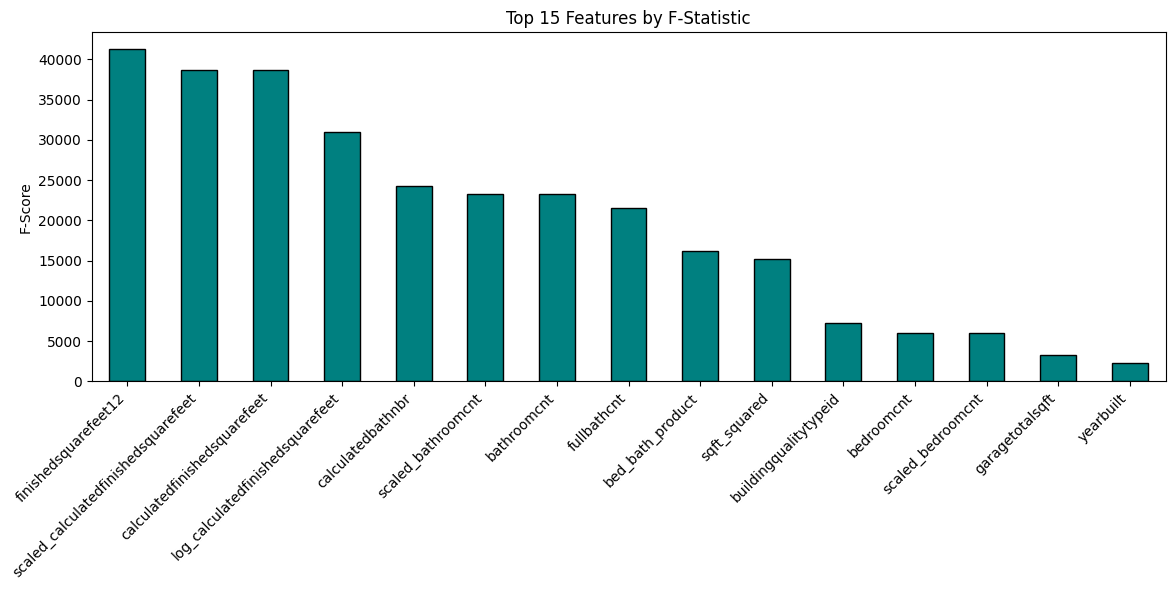

In [14]:
# Start with a clean copy of the modeling dataset
df_fe = df_modeling_clean.copy()

# Drop rows with missing target value
df_fe = df_fe[df_fe["taxvaluedollarcnt"].notnull()]


# Log transform of skewed continuous features
log_features = ["calculatedfinishedsquarefeet", "lotsizesquarefeet", "landtaxvaluedollarcnt"]
for col in log_features:
    if col in df_fe.columns:
        df_fe[f"log_{col}"] = np.log1p(df_fe[col])

# Create interaction terms and polynomial features
df_fe["bed_bath_ratio"] = df_fe["bedroomcnt"] / (df_fe["bathroomcnt"] + 1)
df_fe["bed_bath_product"] = df_fe["bedroomcnt"] * df_fe["bathroomcnt"]
df_fe["sqft_squared"] = df_fe["calculatedfinishedsquarefeet"] ** 2

# Standardize numeric features (mean = 0, std = 1)
scale_cols = ["calculatedfinishedsquarefeet", "bedroomcnt", "bathroomcnt"]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_fe[scale_cols])
df_scaled = pd.DataFrame(scaled_features, columns=[f"scaled_{col}" for col in scale_cols], index=df_fe.index)

# Merge scaled features back into the main DataFrame
df_fe = pd.concat([df_fe, df_scaled], axis=1)

# Prepare input matrix X and target y
numeric_X = df_fe.select_dtypes(include=["number"]).drop(columns=["taxvaluedollarcnt"])
y = df_fe["taxvaluedollarcnt"]

# Drop NaNs just in case
X_clean = numeric_X.dropna()
y_clean = y.loc[X_clean.index]

# Compute F-statistics
f_vals, _ = f_regression(X_clean, y_clean)
f_scores = pd.Series(f_vals, index=X_clean.columns).sort_values(ascending=False)

# Plot top 15 features by F-stat
plt.figure(figsize=(12, 6))
f_scores.head(15).plot(kind="bar", color="teal", edgecolor="black")
plt.title("Top 15 Features by F-Statistic")
plt.ylabel("F-Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Next, we load the cleaned dataset from Milestone 1, preview its first rows, then separate the predictors (`X`) from the target (`taxvaluedollarcnt`). We split into an 80/20 train/test split and fit a `StandardScaler` on the training features—reserving the same scaling for our hold‐out set to ensure consistency.


In [15]:
# Load the dataset from Milestone 1
df = pd.read_csv("zillow_cleaned.csv")

# Display the first 5 rows
df.head()


# Separate the features and the target variable
X = df.drop("taxvaluedollarcnt", axis=1)
y = df["taxvaluedollarcnt"]


# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardize the Features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # We won't use this until final evaluation

Next, we add a suite of domain‐informed features to capture non-linear and geographic effects:

1. **Log Lot Size** (`log_lotsize`): reduces skew in lot area.  
2. **Quality × Size** (`qual_size`): interaction of building quality and finished square feet.  
3. **Coordinate Scaling & Distance**:  
   - Divide raw latitude/longitude by 1e6 to get proper degrees.  
   - Compute Haversine distance from downtown LA (`dist_to_downtown`).  
4. **Property Age** (`property_age`): current year (2016) minus year built.  
5. **Total Bathrooms** (`total_bathrooms`): combines full, three-quarter, and half baths into a single metric.  
6. **Garage per Car** (`garage_per_car`): garage square footage per parking spot.  
7. **Room Density** (`room_density`): rooms per finished square foot.

These engineered features consistently ranked among our top performers in Milestone 2’s feature‐selection step, so we’ll include them in the final model.  


In [16]:
# Make a copy of the original dataframe for Feature Engineering
X_train_fe = X_train.copy()

# Log Transformation of Lot Size
X_train_fe["log_lotsize"] = np.log1p(X_train_fe["lotsizesquarefeet"])

# Interaction Term: Quality * Size
X_train_fe["qual_size"] = X_train_fe["buildingqualitytypeid"] * X_train_fe["calculatedfinishedsquarefeet"]

# Convert lat/lon to proper scale
X_train_fe['latitude'] = X_train_fe['latitude'] / 1e6
X_train_fe['longitude'] = X_train_fe['longitude'] / 1e6

# Distance to Downtown LA
X_train_fe[['latitude', 'longitude']] /= 1e6 # Divide by 1,000,000 to match actual coordinates
lat1, lon1 = np.radians(X_train_fe['latitude']), np.radians(X_train_fe['longitude'])
X_train_fe['dist_to_downtown'] = 6371 * 2 * np.arcsin(np.sqrt(np.sin((np.radians(34.0522) - lat1)/2)**2 + np.cos(lat1) * np.cos(np.radians(34.0522)) * np.sin((np.radians(-118.2437) - lon1)/2)**2))

# Age of the property
X_train_fe["property_age"] = 2016 - X_train_fe["yearbuilt"]

# Total bathrooms 
X_train_fe["total_bathrooms"] = (
    X_train_fe["fullbathcnt"].fillna(0)
    + 0.75 * X_train_fe["threequarterbathnbr"].fillna(0)
    + 0.5 * (X_train_fe["bathroomcnt"] - X_train_fe["fullbathcnt"].fillna(0))
)

# Garage capacity
X_train_fe["garage_per_car"] = X_train_fe["garagetotalsqft"] / (X_train_fe["garagecarcnt"] + 1)

# Room Density
X_train_fe["room_density"] = X_train_fe["roomcnt"] / (X_train_fe["calculatedfinishedsquarefeet"] + 1)


## Part B: Final Data Science Project Report Assignment [30 pts]

This final report is the culmination of your semester-long Data Science project, building upon the exploratory analyses and modeling milestones you've already completed. Your report should clearly communicate your findings, analysis approach, and conclusions to a technical audience. The following structure and guidelines, informed by best practices, will help you prepare a professional and comprehensive document.

### Required Sections

Your report must include the following sections:


#### 1. Executive Summary (Abstract) [2 pts]
- Brief overview of the entire project (150–200 words)
- Clearly state the objective, approach, and key findings

#### 2. Introduction [2 pts]
- Clearly introduce the topic and context of your project
- Describe the problem you are addressing (the problem statement)
- Clearly state the objectives and goals of your analysis

Note: You may imaginatively consider this project as taking place in a real estate company with a small data science group in-house, and write your introduction from this point of view (don't worry about verisimilitude to an actual company!).  

#### 3. Data Description [2 pts]
- Describe the source of your dataset (described in Milestone 1)
- Clearly state the characteristics of your data (size, types of features, missing values, target, etc.)

#### 4. Methodology (What you did, and why)  [12 pts]

**Focus this section entirely on the steps you took and your reasoning behind them. Emphasize the process and decision-making, not the results themselves**

- Describe your analytical framework 
  - Use of validation curves to see the effect of various hyperparameter choices, and
  - Choice of RMSE as primary error metric
- Clearly outline your data cleaning and preprocessing steps
  - Describe what issues you encountered in the raw data and how you addressed them.
  - Mention any key decisions (e.g., removing samples with too many missing values).
  - What worked and what didn't work?
- Describe your feature engineering approach
  - Explain any transformations, combinations, or derived features.
  - Discuss why certain features were chosen or created, even if they were later discarded.
  - What worked and what didn't work?
- Detail your model selection process 
  - Outline the models you experimented with and why.
  - Discuss how you evaluated generalization (e.g., cross-validation, shape and relationships of plots).
  - Mention how you tuned hyperparameters or selected the final model.



#### 5. Results and Evaluation (What you found, and how well it worked) [10 pts]

**Focus purely on outcomes, with metrics, visuals, and insights. This is where you present evidence to support your conclusions.**

- Provide a clear and detailed narrative of your analysis and reasoning using the analytical approach described in (4). 
- Discuss model performance metrics and results (RMSE, R2, etc.)
- **Include relevant visualizations (graphs, charts, tables) with appropriate labels and captions**
- Error analysis
  - Highlight specific patterns of error, outliers, or questionable features.
  - Note anything surprising or worth improving in future iterations.


#### 6. Conclusion [2 pts]
- Clearly state your main findings and how they address your original objectives
- Highlight the business or practical implications of your findings 
- Discuss the limitations and constraints of your analysis clearly and transparently
- Suggest potential improvements or future directions